# Text Summarizer

The aim of this project is to build a text summarizer that summarize Amazon Reviews. There is an enourmous amount of text in the world today. 

Automatic summarization is the process of shortening a text document with software, in order to create a summary with the major points of the original document. 

This model could be addapted to fields such as Medical summarization or summarizing papers. 

In [26]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# basic imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import fastText as ft
import os
import pickle
import random
import sys

# torch imports 
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch
from torch.autograd import Variable

# my file imports 
from utils import save_array, load_array, get_vecs
from preprocessing import Tokenizer, TextDataSet, limit_unk_vocab
from dataset import TextDataLoader
from model import Seq2SeqAttention
from train import fit

import warnings
warnings.filterwarnings('ignore')

Lets read the data in. You can easily get this data from [Kaggle's Amazon Fine Food Reviews'](https://www.kaggle.com/snap/amazon-fine-food-reviews/data). And store the `Reviews.csv` file in the `data/` directory. 

In [27]:
DATA_PATH = 'data/'
reviews = pd.read_csv(f'{DATA_PATH}Reviews.csv', usecols=['Summary', 'Text'])
# drop rows with no Summary
reviews.dropna(inplace=True)
# drop duplicated 
reviews.drop_duplicates(['Text'], keep='first', inplace=True)
print('total reviews', reviews.shape[0])
reviews.head(5)

total reviews 393576


,Summary,Text
0,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,"""Delight"" says it all",This is a confection that has been around a fe...
3,Cough Medicine,If you are looking for the secret ingredient i...
4,Great taffy,Great taffy at a great price. There was a wid...


Lets plot some basic text and summary length plots. This will also give us some intuition based on our 'padding' we perform later

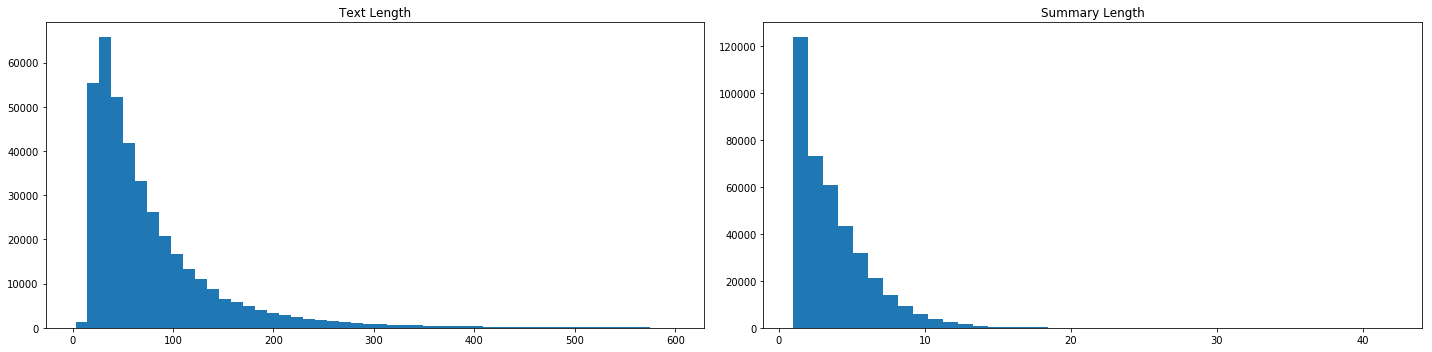

In [3]:
reviews['Summary_len'] = reviews.Summary.apply(lambda x: len(x.split()))
reviews['Text_len'] = reviews.Text.apply(lambda x: len(x.split()))  

plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.hist(reviews.Text_len[reviews['Text_len'] < 600], bins=50)
plt.title('Text Length')

plt.subplot(1, 2, 2)
plt.hist(reviews['Summary_len'], bins=40)
plt.title('Summary Length')
plt.tight_layout()

Typical log normal distribution. You can see that there are some very short reviews in this dataset. Checking a few out manually, many have no relevance for our task, so they can simply be dropped. 

In [4]:
# drop short reviews < 10
reviews = reviews[reviews['Text_len'] > 10]
print('total reviews', reviews.shape[0])

total reviews 393470


Lets split the data into training and testing so we can have a fair estimate in how our model would perform on out-of-sample data. This is definitely a required step in this particular project, since we are planning on using teacher forcing (explained later) in the training phase. 

In [5]:
train_df, test_df = train_test_split(reviews, test_size=0.1, random_state=100)

## Pre-Processing Text
To create the lengths of `idx2word` and `word2idx` we can check out the percentile values from the training set for the Text and Summary lengths. We use 90% for text and 99% for the summary. We can chop off a bit more text to reduce the padded tokens, but we keep most of the summary length and just pad. As you can see later we choose 150 for the text length and 12 for the summary length.

In [6]:
print('Text length 90 percentile:', np.percentile(train_df.Text_len, 90))
print('Summary length 99 percentile:', np.percentile(train_df.Summary_len, 99))

Text length 90 percentile: 159.79999999998836
Summary length 99 percentile: 12.0


To create our `idx2word` and `word2idx` we concatenate our reviews and summaries into one long corpus. It make sense that our `idx2word` and `word2idx` should contain all the tokens we have in our dataset. 

This `TextDataSet` class does does all the pre-processing for us. First it tokenizes the data with [spacy](https://spacy.io/)  

Another thing to note here is that the `Tokenizer()` class uses multiprocessing and paralizes multiple cores on your machince. This is definitely necessary when trying to process this many reviews at once. 

I found this out the hard way. Before using multiprocessing and "chunking", this code cell below took 9 hours to run, now it takes around one minute to complete. You can check out the code [here](LINK) in how this was done.

If you want to learn a bit more in how to use the [multiprocessing](https://docs.python.org/2/library/multiprocessing.html) library, you might find this [basic tutorial helpful](https://www.youtube.com/watch?v=oEYDqQ1pq9o)

In [7]:
%%time
max_vocab_text = 10000
maxlen_text = 150
maxlen_summary = 12

# all text model
all_text_raw = np.concatenate([train_df.Text.values, train_df.Summary.values])

all_text_model = TextDataSet(max_vocab=max_vocab_text, maxlen=maxlen_text, min_freq=2, padding='post')
all_text = all_text_model.fit(all_text_raw, tokenize=True)

CPU times: user 7.42 s, sys: 821 ms, total: 8.24 s
Wall time: 1min 5s


Now we can `transform` our `Text` and `Summary` fields to create our padded text and summary. One thing to note here is that we add a beginning of sentence tag (`_bos_`) and end of sentence tag (`_eos_`) to the `Summary` field. This is necessary so the model can learn when to stop which helps computation time. 

In [8]:
%%time
# Text Field
train_text = all_text_model.transform(train_df.Text.values, word2idx=all_text_model.word2idx, padding='pre')
test_text = all_text_model.transform(test_df.Text.values, word2idx=all_text_model.word2idx, padding='pre')

# Summary
train_df['Summary'] = '_bos_' + ' ' + train_df['Summary'] + ' ' + '_eos_'
test_df['Summary'] = '_bos_' + ' ' + test_df['Summary'] + ' ' + '_eos_'

train_summary = all_text_model.transform(train_df.Summary.values, word2idx=all_text_model.word2idx, maxlen=maxlen_summary, padding='post')
test_summary = all_text_model.transform(test_df.Summary.values, word2idx=all_text_model.word2idx, maxlen=maxlen_summary, padding='post')

CPU times: user 14.7 s, sys: 2.16 s, total: 16.8 s
Wall time: 56.7 s


Another thing we do here to limit the amount of data here is to limit the data to only have 2 UNK occurnces in text and 1 UNK occurance in summary.  This is done to ensure that we are building the model with meaningful data.

In [9]:
%%time
max_unk_text = 1
max_unk_summary = 0

train_text, train_summary = limit_unk_vocab(train_text, train_summary, all_text_model, max_unk_text, max_unk_summary)

new text size 218672
new summary size 218672
CPU times: user 57.4 s, sys: 130 ms, total: 57.5 s
Wall time: 57.6 s


A simple cell to save / load the data and model. Upate the `SAVE` and `LOAD` flags appropiately. 

In [10]:
SAVE = True
LOAD = False

if SAVE:
    save_array(all_text, 'all_text.npy')
    save_array(train_text, 'train_text.npy')
    save_array(test_text, 'test_text.npy')
    save_array(train_summary, 'train_summary.npy')
    save_array(test_summary, 'test_summary.npy')
    
if LOAD:  
    # TODO pickle model
    max_vocab_text = 10000
    maxlen_text = 150
    maxlen_summary = 12
    
    all_text_raw = np.concatenate([train_df.Text.values, train_df.Summary.values])
    all_text_model = TextDataSet(max_vocab=max_vocab_text, maxlen=maxlen_text, min_freq=2, padding='post')
    all_text = all_text_model.fit(all_text_raw, tokenize=True)
    all_text = load_array('all_text.npy')
    train_text = load_array('train_text.npy')
    test_text = load_array('test_text.npy')
    train_summary = load_array('train_summary.npy')
    test_summary = load_array('test_summary.npy')

## Embeddings 

For our word vectors for our model, have decided to go with the Pre-trained [fasttext word vectors](https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md). Make sure you download the english  "bin+text" and save the `wiki.en.bin` file in your `data/` path.  

Direct link for the download is [here](https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.zip). 


Then you can run this code below to pickle and return the word vectors. If you have already pickled the files, you can just read them from disk. 

In [11]:
download_vectors = False

if download_vectors:
    # warning this is not tested, since I removed my file, but should work  
    word_vector_path = os.path.join(DATA_PATH, 'wiki.en.bin')
    en_vecs = ft.load_model(word_vector_path)
    en_vecd = get_vecs(en_vecs)
else:
    en_vecd = pickle.load(open(os.path.join(DATA_PATH, 'wiki.en.pkl'),'rb'))
    dim_en_vec = len(en_vecd[','])

print('word embedding shape', dim_en_vec)

word embedding shape 300


# Get Data

Let's create our pytorch `Dataset` and load in the data. This makes our life much easier since it bathces the data for us!

If you are not using a GPU would suggest using using a `subset` of the data, since this model takes a long time to train and you can still get some good results with `10000` datapoints.

In [12]:
reduced_set = True

subset = None
if reduced_set:
    subset = 10000

train_loader = DataLoader(TextDataLoader(train_text[:subset], train_summary[:subset], transpose=False), batch_size=32)
test_loader = DataLoader(TextDataLoader(test_text[:subset], test_summary[:subset], transpose=False), batch_size=32) 

print('training set size:', len(train_loader.dataset))
print('testing set size:', len(test_loader.dataset))

training set size: 10000
testing set size: 10000


# Model

Now lets initialize our model. There is really only one valid choice any more in NLP tasks. Can you guess what it is? Yup, you guesed it! Bi-directional RNN with attention! 

Therefore we have decided to use a GRU, initialize with the FastText word embeddings, 256 hidden nodes for the RNN, 2 layers for the RNN, and use tanh for the activation in the attention mechanism.

You can check out the full model implemention in the [model.py](LINK) file. 

In [33]:
num_hidden = 256
num_layers = 2
activation = F.tanh

model = Seq2SeqAttention(vecs_enc=en_vecd, idx2word_enc=all_text_model.idx2word, em_sz_enc=dim_en_vec, 
                         vecs_dec=en_vecd, idx2word_dec=all_text_model.idx2word, em_sz_dec=dim_en_vec, 
                         num_hidden=num_hidden, out_seq_length=maxlen_summary, num_layers=num_layers, 
                         activation=activation, pad_idx=all_text_model.word2idx['_pad_']).cuda()

In [30]:
model

Seq2SeqAttention(
  (encoder_embeddings): Embedding(10004, 300, padding_idx=1)
  (encoder_dropout_emb): Dropout(p=0.1)
  (encoder_dropout): Dropout(p=0.1)
  (encoder_gru): GRU(300, 256, num_layers=2, bidirectional=True)
  (encoder_out): Linear(in_features=512, out_features=300, bias=False)
  (decoder_embeddings): Embedding(10004, 300, padding_idx=1)
  (decoder_dropout): Dropout(p=0.1)
  (decoder_gru): GRU(300, 300, num_layers=2)
  (out): Linear(in_features=256, out_features=10004, bias=True)
  (l2): Linear(in_features=300, out_features=300, bias=True)
  (l3): Linear(in_features=812, out_features=300, bias=True)
)

# Fit Model 

In [37]:
%%time
tr_ratios = np.concatenate([np.array([0.9]*50), np.linspace(0.9, 0, 50)])
# tr_ratios = np.ones(30)
history = fit(model, train_loader, val_loader=test_loader, learning_rate=1e-4, epochs=len(tr_ratios), 
            grad_clip=5.0, pad=all_text_model.word2idx['_pad_'], tr_ratios=tr_ratios, 
            print_period=100, save=True, return_history=True)

HBox(children=(IntProgress(value=0, description='Epoch'), HTML(value='')))


epoch_loss: 3.60499, % of epoch: (96%)
 [1, 4.44518118540446, 6.898240498243234]
epoch_loss: 2.75118, % of epoch: (96%)
 [2, 2.958540711402893, 7.078223631168023]
epoch_loss: 2.64331, % of epoch: (96%)
 [3, 2.722515640258789, 6.574918342706485]
epoch_loss: 2.57258, % of epoch: (96%)
 [4, 2.5755149551232654, 6.447262495756149]
epoch_loss: 2.51723, % of epoch: (96%)
 [5, 2.4818871649106344, 6.064469416936238]
epoch_loss: 2.36573, % of epoch: (96%)
 [6, 2.3756611057122545, 6.35491386667276]
epoch_loss: 2.29620, % of epoch: (96%)
 [7, 2.2880670539538066, 6.206605556683662]
epoch_loss: 2.29683, % of epoch: (96%)
 [8, 2.270700417757034, 5.743541839795235]
epoch_loss: 2.25102, % of epoch: (96%)
 [9, 2.191763353745143, 5.711709465735998]
epoch_loss: 2.23032, % of epoch: (96%)
 [10, 2.155494833389918, 5.775844345490138]
epoch_loss: 2.20001, % of epoch: (96%)
 [11, 2.144325837294261, 5.652950287629396]
epoch_loss: 2.24057, % of epoch: (96%)
 [12, 2.127721463839213, 5.324703744588754]
epoch_loss

In [38]:
torch.save(model, 'models/reduced_100_epoch_no_shuffle.pth.tar')

# Training / Testing Loss

We can plot the training and validation loss. We can also overlay the teacher forcing ratios. 

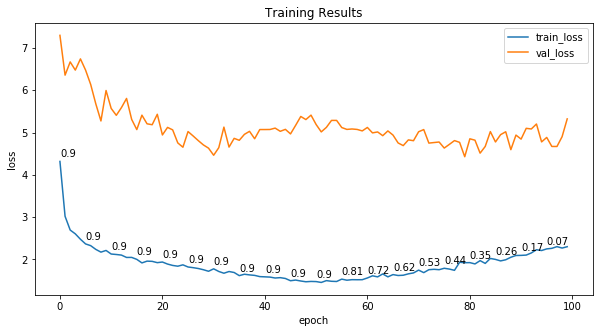

In [49]:
def plot_loss(history, every=1):
    plt.figure(figsize=(10, 5))
    plt.plot(history['train_loss'], label='train_loss')
    plt.plot(history['val_loss'], label='val_loss')
    for i, (loss, tr_ratio) in enumerate(zip(history['train_loss'], tr_ratios)):
        if i % every == 0:
            plt.annotate(str(np.round(tr_ratio, 2)), xy=(float(i), loss+0.1))
    plt.legend()
    plt.title('Training Results')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()
    
plot_loss(history2, 5)

We can also check out the cyclical learning rates.

Text(0,0.5,'iterations')

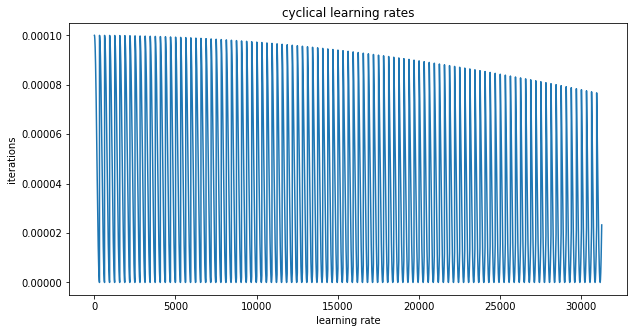

In [41]:
plt.figure(figsize=(10, 5))
plt.plot(history['all_lr']);
plt.title('cyclical learning rates')
plt.xlabel('learning rate')
plt.ylabel('iterations')

# Extrinsic Evaluation

Now we can see how the model actually performs. Another cool thing we can do with an attention model, is check out the softmax weights for each of the input words in the text.  

In [50]:
import torch
from torch.autograd import Variable

def get_max(probs, top=2, unk=0):
    preds = []
    for top_preds in probs.topk(top)[1].data.cpu().numpy():
        top_preds = top_preds.flatten()
        final_pred = top_preds[0]
        if top > 1: 
            if top_preds[0] == unk:
                print(top_preds[0])
                final_pred = top_preds[1]
        preds.append(final_pred)
    return preds

def get_idx2word(data, idx, idx2word, pad=1):
    return [idx2word[i] for i in data[idx] if i != pad]

def generate_example(model, text=None, summary=None, idx=None, plot_attention=False, pad=1, unk=0):
    if idx is None:
        idx = np.random.randint(0, len(train_text_reduced), size=1)[0]
    x = np.expand_dims(text[idx], 1)
    y = np.expand_dims(summary[idx], 1)
    x_v = Variable(torch.from_numpy(x).long()).cuda()
    y_v = Variable(torch.from_numpy(y).long()).cuda()

    probs, attentions = model(x_v, y_v, return_attention=True)
    original_text = get_idx2word(text, idx, all_text_model.idx2word, pad=pad)
    original_text_len = len(original_text)
    original_summary = get_idx2word(summary, idx, all_text_model.idx2word, pad=pad)
    preds = [all_text_model.idx2word[i] for i in get_max(probs, unk=unk) if i != pad]
    print('ORIGINAL TEXT:')
    print(' '.join(original_text))
    print('ORIGINAL SUMMARY:')
    print(' '.join(original_summary))
    print('MODEL PREDICTION:')
    print(' '.join(preds))
    if plot_attention:
        plt.figure(figsize=(15, 5))
        x = attentions.data[0].cpu().numpy()[maxlen_text - original_text_len:]
        plt.plot(x, 'o')
        plt.xticks(range(len(x)), original_text, rotation='vertical');
        plt.title('Attention Weights')
        plt.ylabel('Softmax Probabilites')
        plt.show()
    print('*'*117)
    print('\n')

Let's generate 10 examples from the training dataset with the corresponding output and attention weights

ORIGINAL TEXT:
these brownies tasted funny . i do n't know how to describe it but i actually had to give them away . would never buy it again or refer it to someone . grainy and weird chocolatey taste and texture . ..
ORIGINAL SUMMARY:
_bos_ chocolatey taste and texture . .. _eos_
MODEL PREDICTION:
_bos_ horrible taste _eos_


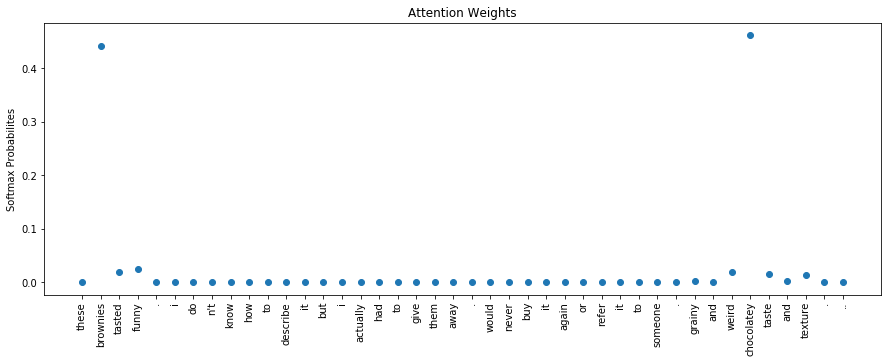

*********************************************************************************************************************


ORIGINAL TEXT:
it is hard to get my 9 month old to eat vegetables , but luckily she likes this blend ! as another review mentioned , it is pretty runny but i just thicken it up with rice cereal . i 'm a little torn on what i think of packages like this - i am glad they are bpa free , and they are convenient for when we 're out and about , but in general i prefer glass containers that we can recycle or reuse .
ORIGINAL SUMMARY:
_bos_ very good _eos_
MODEL PREDICTION:
_bos_ easy and tasty _eos_


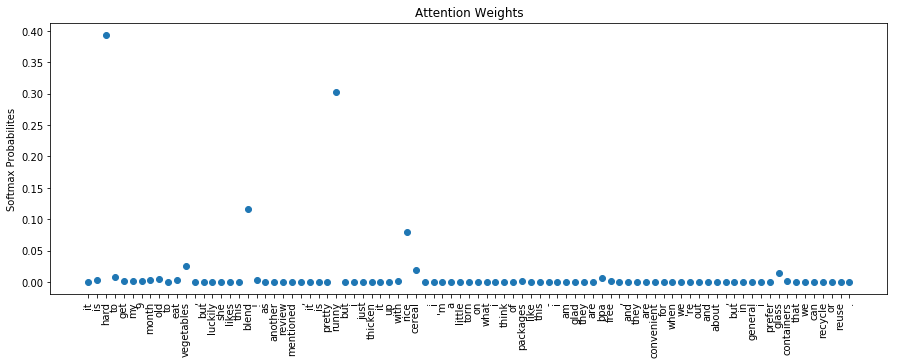

*********************************************************************************************************************


ORIGINAL TEXT:
after using erythritol in several recipes i 've found that it tastes far better than alternate sweeteners like splenda . it is a little less sweet than sugar or splenda so you might have to add a bit more to get the same taste . the only problem with erythritol is that it does n't break down easily in _unk_ or recipes that do n't require some amount of cooking or baking . i 've found running it through a blender to break it down into a powder or mixing it with warm water before mixing it in removes the grainy texture and makes the erythritol easier to work with .
ORIGINAL SUMMARY:
_bos_ great but grainy _eos_
MODEL PREDICTION:
_bos_ great for _eos_


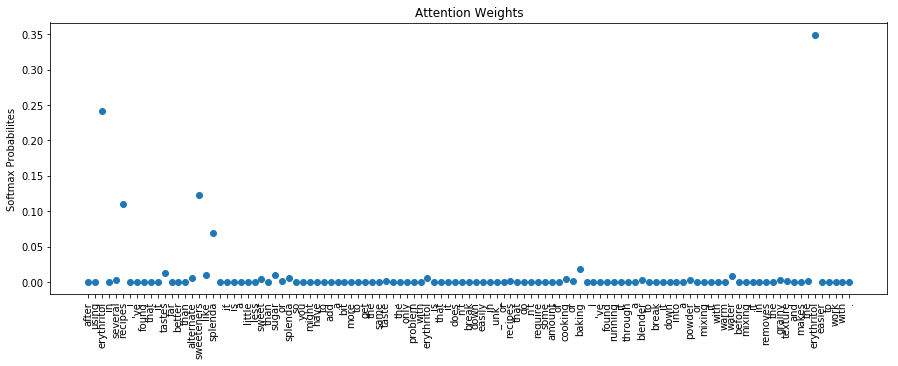

*********************************************************************************************************************


ORIGINAL TEXT:
i purchased this tea for my mom because she ca n't have caffiene . i chose this brand because i was tired of looking , my _unk_ loves it and trust me she knows her tea . she uses a tea infuser to brew the tea and now only drinks this tea .
ORIGINAL SUMMARY:
_bos_ if mom says it 's good ... _eos_
MODEL PREDICTION:
_bos_ my son loves it _eos_


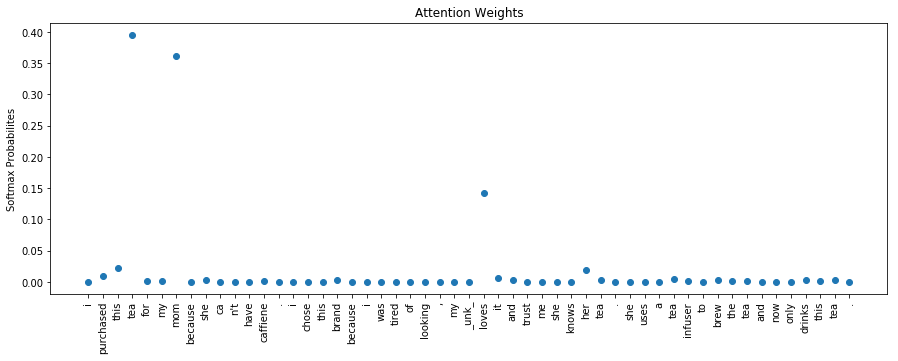

*********************************************************************************************************************


ORIGINAL TEXT:
after no longer being able to find this product in our local stores . we are so happy that we found a place to buy the chicken helper cheesy chicken _unk_ . this product is no only delicious but a fast easy meal . i use can chicken and that makes this a super fast meal . the shipping was really fast too . thanks
ORIGINAL SUMMARY:
_bos_ we love this product _eos_
MODEL PREDICTION:
_bos_ great product _eos_


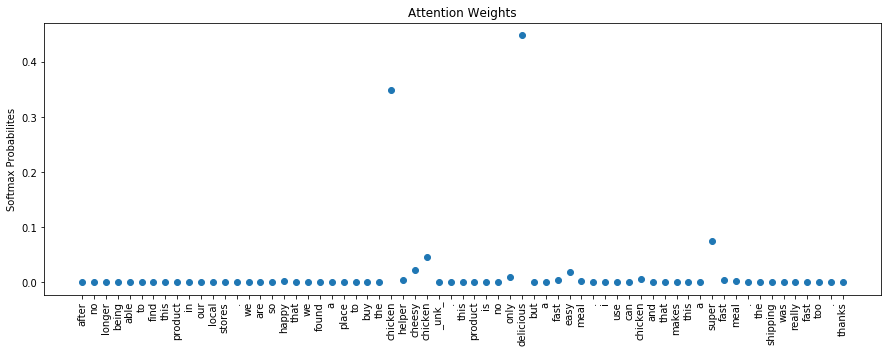

*********************************************************************************************************************


ORIGINAL TEXT:
these are the best wasabi peas around . they 're hot , with a little bit of sweet . much more flavorful than the other brands . these are the best , without a doubt .
ORIGINAL SUMMARY:
_bos_ the best wasabi peas _eos_
MODEL PREDICTION:
_bos_ the best wasabi peas


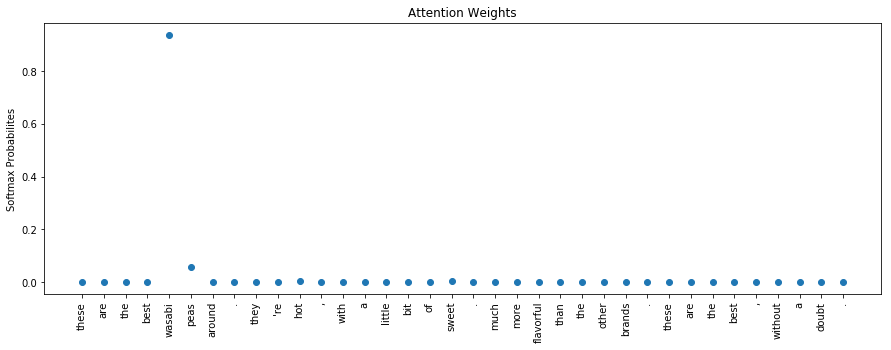

*********************************************************************************************************************


ORIGINAL TEXT:
good product at a fraction of the candy store price , plus free super saver shipping .
ORIGINAL SUMMARY:
_bos_ great value _eos_
MODEL PREDICTION:
_bos_ great price _eos_


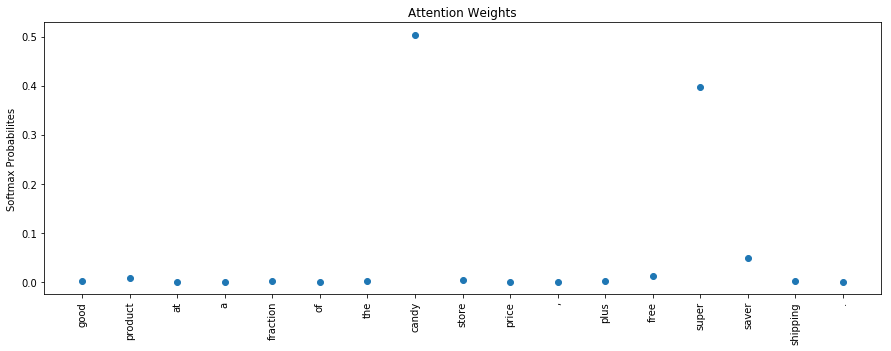

*********************************************************************************************************************


ORIGINAL TEXT:
with all the organic , single - origin , fair trade , 80 % + dark chocolates available even in discount stores , i am not quite sure why newman 's own brand wanted to get in the chocolate business . anyway , this is a very light - weight entry into the _unk_ , and at only 54 % pure chocolate ( in the vine sample i received , anyway ) , a quite weak entry at that . it tasted okay , but definitely too sweet and lacking the earthy bitter - sweet taste of the more cacao bean - heavy chocolates available . not much different than a decent hershey dark chocolate bar , and likely much more expensive .
ORIGINAL SUMMARY:
_bos_ a little too sweet ... _eos_
MODEL PREDICTION:
_bos_ not but not as


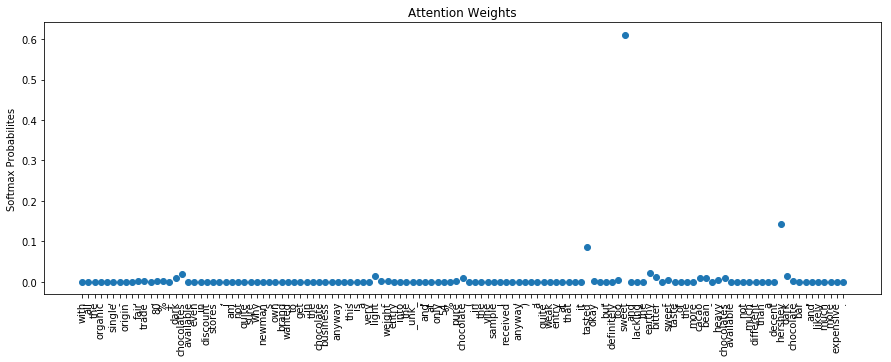

*********************************************************************************************************************


ORIGINAL TEXT:
this canned pumpkin was purchased for my dogs , wonderful benefits for _unk_ . no dented cans , good packaging . i will never buy any other pumpkin again even for my family 's use . the pumpkin we used to buy in the grocery store is watery , this pumpkin is firm , no filler or artificial coloring . texture is similar to stiff mashed potatoes . simply the best ! !
ORIGINAL SUMMARY:
_bos_ got ta be the best _eos_
MODEL PREDICTION:
_bos_ best canned ever _eos_


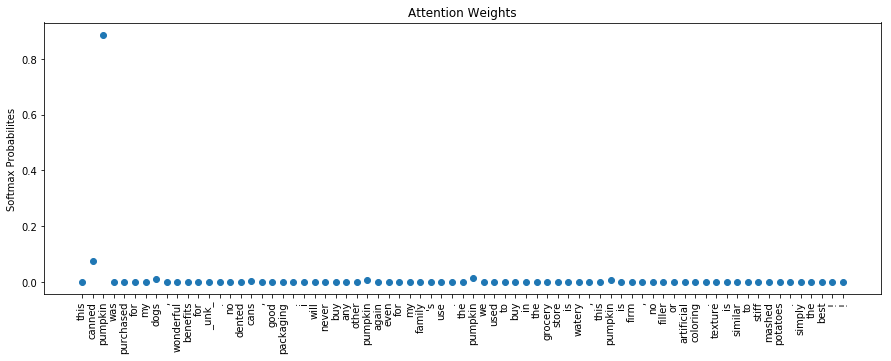

*********************************************************************************************************************


ORIGINAL TEXT:
the coffee arrive on time and the quality was as good as always . i have ordered this product several times and it has always been as advertised . i will order it again in the future .
ORIGINAL SUMMARY:
_bos_ green mountain fair trade colombian _eos_
MODEL PREDICTION:
_bos_ great coffee _eos_


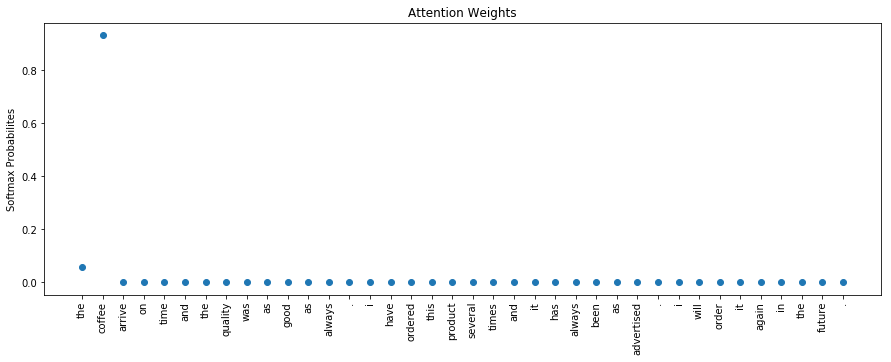

*********************************************************************************************************************




In [52]:
for idx in range(100, 110):
    generate_example(model, text=train_text, summary=train_summary, idx=idx, plot_attention=True, 
                     pad=all_text_model.word2idx['_pad_'], unk=all_text_model.word2idx['_unk_'])

Let's generate 10 examples from the validation dataset with the corresponding output and attention weights

ORIGINAL TEXT:
we first went from 4 boxes to 3 .... now we went from 8 + dollars to > 14 dollars . i will not pay this . walmart and food lion are much much _unk_ now . i will cancel this subscription today . makes no since .
ORIGINAL SUMMARY:
_bos_ hate the price increase ! ! ! _eos_
MODEL PREDICTION:
_bos_ very 's _eos_ _eos_


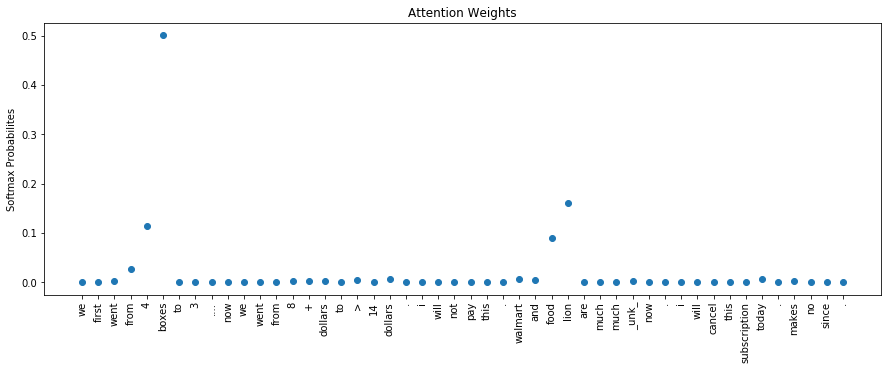

*********************************************************************************************************************


ORIGINAL TEXT:
really nice seasoning ! have bought this product before at sam 's club and am happy to be able to purchase it here as i can not get to sam 's anymore . i use it on my meats and in spaghetti . :)
ORIGINAL SUMMARY:
mccormick italian spaghetti sauce , _unk_ ( pack of 3 ) _eos_
MODEL PREDICTION:
_bos_ great ! _eos_


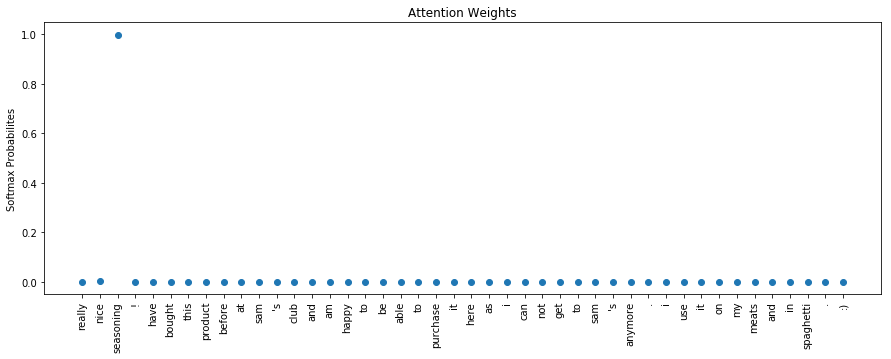

*********************************************************************************************************************


ORIGINAL TEXT:
my dogs enjoy any type of " puppy cookie " , they 're not picky at all . but i noticed that in feeding them this product they started to prefer this brand over all others ! i am happy knowing they enjoy it , but i 'm even happier knowing that it is filled with all sorts of good " real " food - not by - products and what not . i would highly recommend these !
ORIGINAL SUMMARY:
_bos_ my dogs loved them ! ! _eos_
MODEL PREDICTION:
_bos_ dogs love ! _eos_


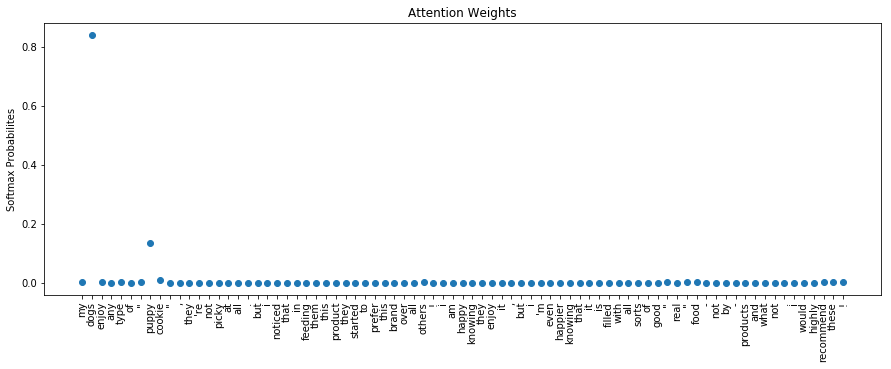

*********************************************************************************************************************


ORIGINAL TEXT:
do not hesitate to buy product from this vendor . product exactly as described . came priority mail within 2 days and there was no breakage or melting ( sept transaction , weather still warm & potential _unk_ to candy during shipping ) . great price , shop around & compare & you will see it is so . i am using these as part of a baby shower favor that takes a ' cup of tea ' theme . the 5 1/2 inch _unk_ add an elegant & fun touch .
ORIGINAL SUMMARY:
_bos_ wonderful shower favor addition .... _eos_
MODEL PREDICTION:
_bos_ great product _eos_


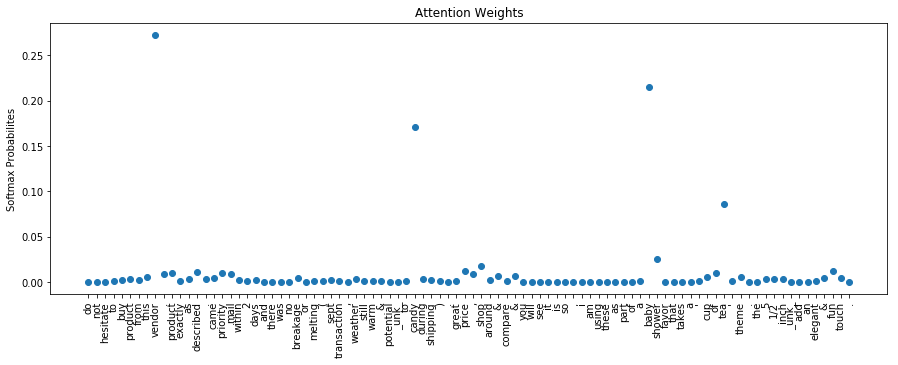

*********************************************************************************************************************


ORIGINAL TEXT:
it appears that the problem i reported with this product has been corrected . my last order was wonderful and i will order this product again .
ORIGINAL SUMMARY:
_bos_ think thin chunky peanut bar _eos_
MODEL PREDICTION:
_bos_ excellent product _eos_


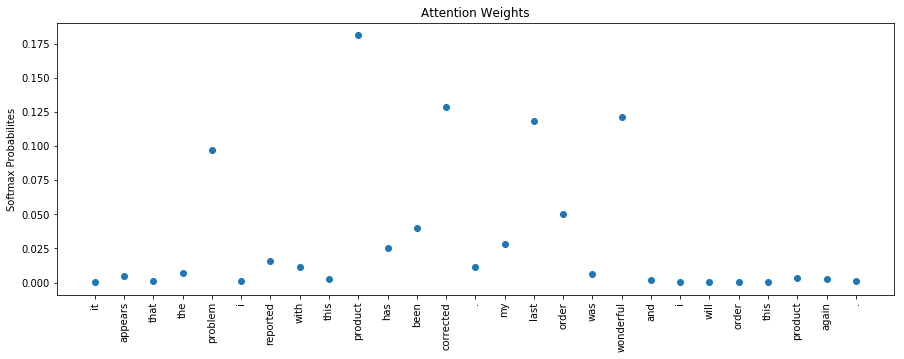

*********************************************************************************************************************


ORIGINAL TEXT:
great tasting drink , and mix with some tropical punch kool - aid makes a _unk_ punch and drink all through out the year also great for parties good source in vitamin c and calcium
ORIGINAL SUMMARY:
use to drink when i was a child , in africa _eos_
MODEL PREDICTION:
_bos_ great treat _eos_ - - - - - - - _eos_


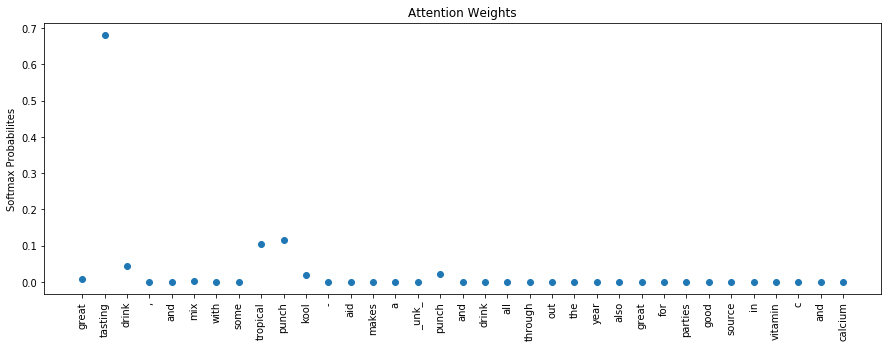

*********************************************************************************************************************


ORIGINAL TEXT:
with peanut sauce . just thinking and talking about it makes my mouth water ! ! i have to thank a wonderful employee at one of my local _unk_ 's for putting to rest the mystery of the peanut sauce they use as it is one of the best i have ever had -- and trust me i have tried a few , as well made some to try to replicate this very one . after asking a few times at different sites , one very kind man helped out and ended my quest . now i will have to stock my cupboards with this fabulous sauce and use it liberally . by the way , i have never been so _unk_ about food like this before -- it 's just that good . cheers to you my fellow peanut sauce junkie , make it a fabulous new year !
ORIGINAL SUMMARY:
_bos_ thank you _unk_ 's ! _eos_
MODEL PREDICTION:
_bos_ best - - _eos_ _eos_


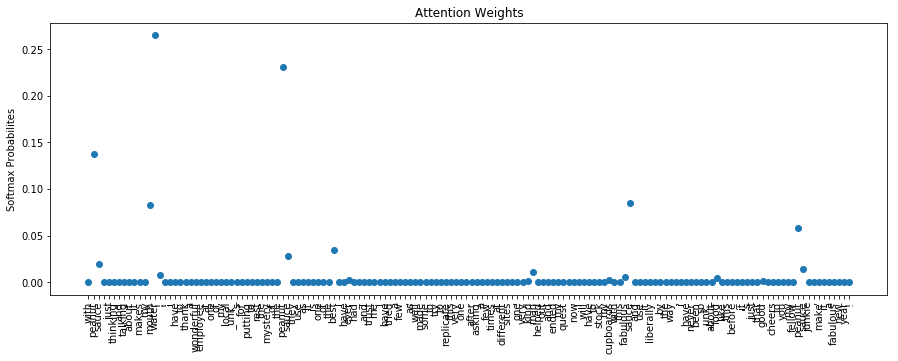

*********************************************************************************************************************


ORIGINAL TEXT:
this water is so good . just a touch sweet which helps me drink even more without sugar :) i 'm in love !
ORIGINAL SUMMARY:
_bos_ wonderful _eos_
MODEL PREDICTION:
_bos_ sweet _eos_


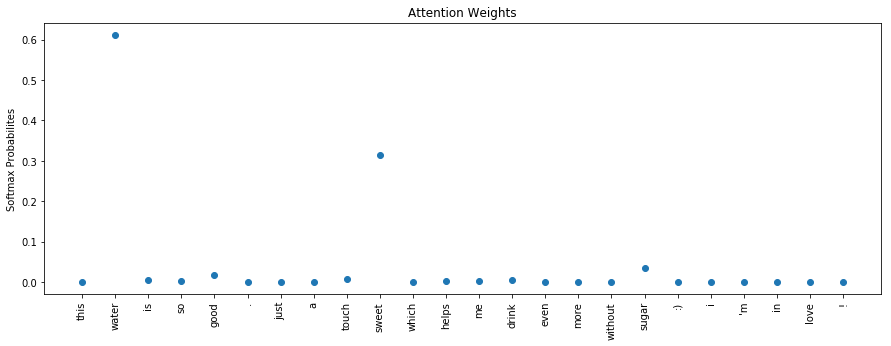

*********************************************************************************************************************


ORIGINAL TEXT:
my face , not greasy like i expected , it absorbs and really makes my skin glow . i put it on my daughter 's _unk_ where she was beginning to get little bumps , and they were gone in 2 days . let 's see , what else ? i am happy to find a natural product that has so many uses . i wish i had know about this last year when i had to go through _unk_ for breast cancer . i have read all kinds of studies where coconut oil has been used to help patients after chemo . i had terrible memory loss and " chemo fog " . will definitely re - order , and send some to my dad who has always worried about the possibility of getting _unk_ . ( google has great information about this . ) hope this helps !
ORIGINAL SUMMARY:
_bos_ love it ! _eos_
MODEL PREDICTION:
_bos_ not as good _eos_ _eos_


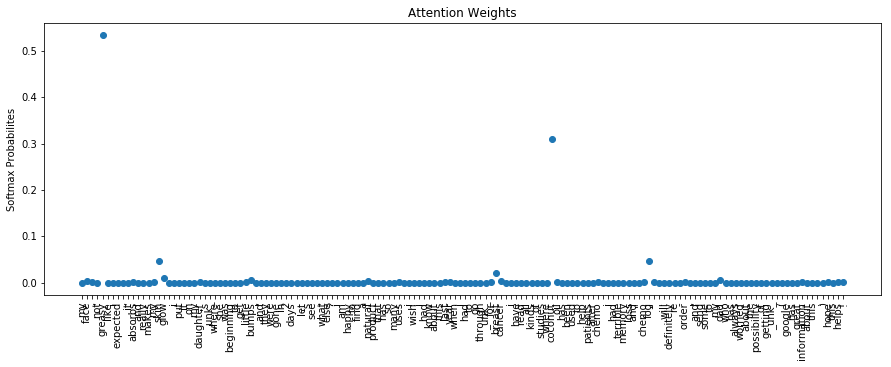

*********************************************************************************************************************


ORIGINAL TEXT:
the packaging was okay on the easter eggs but they were all melted and the chocolate was white , very _unk_ ! we could n't even eat them we had to throw them away . it would have been the same as throwing the money in the trash .
ORIGINAL SUMMARY:
_bos_ not as described _eos_
MODEL PREDICTION:
_bos_ terrible _eos_ _eos_


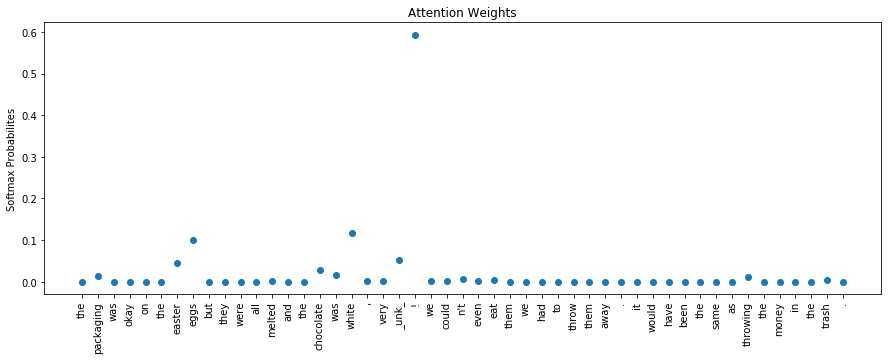

*********************************************************************************************************************




In [55]:
for idx in range(10, 20):
    generate_example(model, text=test_text, summary=test_summary, idx=idx, plot_attention=True, 
                     pad=all_text_model.word2idx['_pad_'], unk=all_text_model.word2idx['_unk_'])

# Future Improvements for 'this' seq-to-seq model
- Test different hyper-parameters for the model. Will more GRU layers help? How about different activation functions in the attention mechanism.
- Reorder the training text so that each batch of text has a similar number of `pad` tokens. Should help the model train a bit faster
- Train the embedding layers
- Different attention mechanisms